# Motor Vehicle Registrations 2000 - 2023
This project examines motor vehicle registrations in the U.S. for the years 2000-2023. Registration data is explored at both the state and national level, and is combined with population data and personal income data.
## Table of Contents
[Data Import](#Data-Import)  
[Data Preprocessing](#Data-Preprocessing)  
[Exploratory Data Analysis and Visualization](#Exploratory-Data-Analysis-and-Visualization)  
[Analysis](#Analysis)

## **Data Import**

### Import Libraries

In [4]:
from itables import init_notebook_mode, show

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import plotly.express as px
import seaborn as sns

### Import Datasets
* Annual Motor Vehicle Registration Data (Motor_Vehicle_Registrations_2000-2023_MV-1.csv)
* Annual State Resident Population Data (historical_state_population_by_year.csv)
* Annual Per-Capita Personal Income by State (SASUMMARY__ALL_AREAS_1998_2024.csv)

Read the CSV files into Pandas dataframes (df) and inspect the first few rows of each dataset (head), the dataset structure (shape), and the data types of each column (dtypes).  

**Annual Motor Vehicle Registrations by State:**

In [6]:
file_path_reg = (r'https://raw.githubusercontent.com/ssolik/motor_vehicle_registrations/main/data/Motor_Vehicle_Registrations_2000-2023_MV-1.csv')
df_reg = pd.read_csv(file_path_reg, encoding='ascii')
print(df_reg.head(5))
print('Shape: ', df_reg.shape)
print(df_reg.dtypes)

   Year    State Category     Type   Vehicles
0  2023  Alabama     Auto  Private  1920522.0
1  2023  Alabama     Auto   Public     1139.0
2  2023  Alabama      Bus  Private     3223.0
3  2023  Alabama      Bus   Public      106.0
4  2023  Alabama    Truck  Private  3390299.0
Shape:  (9880, 5)
Year          int64
State        object
Category     object
Type         object
Vehicles    float64
dtype: object


**Annual State Resident Population by State:**

In [8]:
file_path_pop = (r'https://raw.githubusercontent.com/ssolik/motor_vehicle_registrations/main/data/historical_state_population_by_year.csv')
df_pop = pd.read_csv(file_path_pop, encoding='ascii')
print(df_pop.head(5))
print('Shape: ', df_pop.shape)
print(df_pop.dtypes)

  State  Year  Population
0    AK  1950      135000
1    AK  1951      158000
2    AK  1952      189000
3    AK  1953      205000
4    AK  1954      215000
Shape:  (6275, 3)
State         object
Year           int64
Population     int64
dtype: object


**Annual Per-Capita Personal Income by State:**

In [10]:
file_path_income = (r'https://raw.githubusercontent.com/ssolik/motor_vehicle_registrations/main/data/SASUMMARY__ALL_AREAS_1998_2024.csv')
df_income = pd.read_csv(file_path_income, encoding='ascii', usecols=['GeoName', 'LineCode', '2023'])
print(df_income.head(5))
print('Shape: ', df_income.shape)
print(df_income.dtypes)

         GeoName  LineCode        2023
0  United States       1.0  22671096.0
1  United States       2.0  19404131.7
2  United States       3.0  15621697.3
3  United States       4.0  27720709.0
4  United States       5.0  23380269.0
Shape:  (784, 3)
GeoName      object
LineCode    float64
2023         object
dtype: object


## **Data Preprocessing**

Dataframes and individual data columns are transformed into a usable structure and format for analysis.

**Define State Abbreviations Mapping Function:**

In [12]:
def state_abbrev_mapping(df, col, output_abbr = False, add_new_col = False, new_col = None,  case = None):
    """
    Converts full US state name to 2-character abbreviation.
    Creates new dataframe column with abbreviation (optional).
    Converts output to upper-case or lowercase (optional).
    
    Parameters:
        df (string): The Pandas dataframe to use.
        col (string): The column with the state name or abbreviation you wish to convert.
        output_abbr (boolean): 
            Output state abbreviation (True)
            Output full state name (False)
        add_new_col (boolean): 
            Add new column (True)
            Overwrite existing column (False)
        new_col (string): Name of new column you wish to add.
        case (string): Specify case for output ('upper', 'lower', or None).

    Returns:
        2-character abbreviation for each state.
    """

    state2abbrev = {'Alabama':'AL','Alaska':'AK','Arizona':'AZ','Arkansas':'AR','California':'CA',
                    'Colorado':'CO','Connecticut':'CT','Delaware':'DE','District of Columbia':'DC',
                    'Florida':'FL','Georgia':'GA','Hawaii':'HI','Idaho':'ID','Illinois':'IL','Indiana':'IN',
                    'Iowa':'IA','Kansas':'KS','Kentucky':'KY','Louisiana':'LA','Maine':'ME','Maryland':'MD',
                    'Massachusetts':'MA','Michigan':'MI','Minnesota':'MN','Mississippi':'MS','Missouri':'MO',
                    'Montana':'MT','Nebraska':'NE','Nevada':'NV','New Hampshire':'NH','New Jersey':'NJ',
                    'New Mexico':'NM','New York':'NY','North Carolina':'NC','North Dakota':'ND','Ohio':'OH',
                    'Oklahoma':'OK','Oregon':'OR','Pennsylvania':'PA','Rhode Island':'RI','South Carolina':'SC',
                    'South Dakota':'SD','Tennessee':'TN','Texas':'TX','Utah':'UT','Vermont':'VT','Virginia':'VA',
                    'Washington':'WA','West Virginia':'WV','Wisconsin':'WI','Wyoming':'WY'}

    #If user does not want to add a new column
    if add_new_col == False:
        #Is the output an abbreviation?
        if output_abbr == True:
            df[col] = df[col].str.strip().replace(state2abbrev)
        else:
            df[col] = df[col]   
        #Does the user want a specific case sensitivity?
        if case == 'upper':
            df[col] = df[col].str.upper()
        elif case == 'lower':
            df[col] = df[col].str.lower()
             
    #If user wants to add a new column      
    if add_new_col == True:
        #If new column name is missing
        if new_col == None:
            #Prompt user to enter a new column name
            print("Error: Please add a column name with new_col = ''")
            return() 
        #Is the output an abbreviation?
        if output_abbr == True:
            df[new_col] = df[col].str.strip().replace(state2abbrev)
        else:
            df[new_col] = df[col]
        #Does the user want a specific case sensitivity?
        if case == 'upper':
            df[new_col] = df[new_col].str.upper()
        elif case == 'lower':
            df[new_col] = df[new_col].str.lower()
    return(df)

**Motor Vehicle Registrations:**  
* Ensure numeric datatype for `Vehicles` field
* Aggregate national totals by `Year`
* Load motor vehicle df and add `State` column for state abbreviations rename `State` to `State_Name` to enable use of `State` for state abbreviations

In [14]:
# Ensure integer datatype for number of vehicles
df_reg['Vehicles'] = df_reg['Vehicles'].astype('Int64')

# Filter out Puerto Rico data since Population and Income data does not include Puerto Rico
df_reg = df_reg[(df_reg['State'] != "Puerto Rico")]

# Rename State column to State_Name for full name of state
df_reg = df_reg.rename(columns={'State': 'State_Name'})

# Call state name mapping function & add state abbreviations to State column
df_reg = state_abbrev_mapping(df_reg, col='State_Name', output_abbr = True, add_new_col = True, new_col = 'State')

In [15]:
# Aggregate national totals by Year
national_totals = df_reg.groupby('Year')['Vehicles'].sum().reset_index()

# Sort national totals by Year in ascending order (oldest to newest)
national_totals = national_totals.sort_values(by='Year', ascending=True)

# Aggregate total vehicles per state-year
total_state_year = df_reg.groupby(['State', 'Year'])['Vehicles'].sum().reset_index()

**Annual State Resident Population:**
* Filter for `Year` between 2000 & 2023
* Ensure numeric datatype for `Year` and `Population` fields
* Filter rows where `Year` is between 2000 & 2023

In [17]:
# Ensure integer datatype for Year and Population
df_pop['Year'] = df_pop['Year'].astype('int64')
df_pop['Population'] = df_pop['Population'].astype('Int64')

# Filter rows where 'Year' is between 2000 & 2023
state_pop = df_pop[(df_pop['Year'] >= 2000) & (df_pop['Year'] <= 2023)]

In [18]:
# Filter rows where 'Year' is = 2023
pop_2023 = state_pop[(state_pop['Year'] == 2023)]

**Annual Per-Capita Personal Income by State:**
* Ensure numeric datatype for `Year` and `Population` fields
* Rename `2023` column to `Income_per_capita`
* Filter rows for individual income

In [20]:
# Filter rows for individual states income
df_income = df_income[(df_income["LineCode"] == 10) & (df_income["GeoName"] != 'United States')]

# Ensure integer datatype for Year and Population
df_income['2023'] = pd.to_numeric(df_income['2023'], errors='coerce')

# Call state name mapping function for income
income2023 = state_abbrev_mapping(df_income, col='GeoName', output_abbr = True, add_new_col = True, new_col = 'State')

# Rename 2023 column to Income per Capita
income2023 = income2023.rename(columns={'2023': 'Income_per_capita'})

# Drop unneccessary columns
income2023 = income2023.drop(['GeoName', 'LineCode'], axis=1)

**Aggregate Total Vehicles per State-Year:**

In [22]:
veh2023 = total_state_year[total_state_year['Year']==2023]

# Merge Registrations with Population
reg_pop_2023 = pd.merge(veh2023, pop_2023, on=['State', 'Year'], how='inner')

# Registrations per 1000
reg_pop_2023['Vehicles_per_1000'] = reg_pop_2023['Vehicles'] / reg_pop_2023['Population'] * 1000

# Merge with income
final2023 = pd.merge(reg_pop_2023, income2023, on='State')

## **Exploratory Data Analysis and Visualization**
**Create Line Plot: National Growth in Registrations**  
Create a visualization to show the national growth in total motor vehicle registrations.

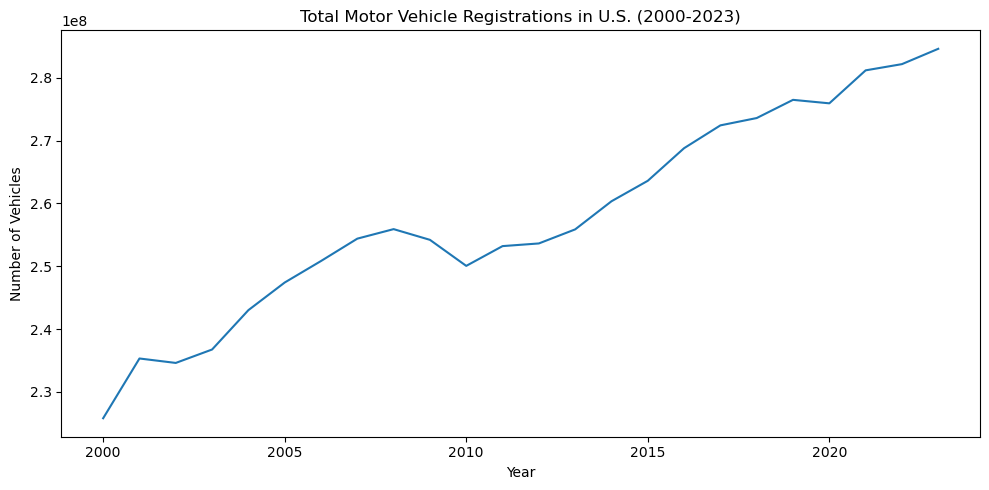

In [24]:
# Line plot national growth
plt.figure(figsize=(10,5))
# sns.lineplot(data=national_totals, x='Year', y='Vehicles', marker='o')
sns.lineplot(data=national_totals, x='Year', y='Vehicles')
plt.title('Total Motor Vehicle Registrations in U.S. (2000-2023)')
plt.xlabel('Year')
plt.ylabel('Number of Vehicles')
#plt.grid(True)
plt.grid(False)
plt.tight_layout()
plt.show()

**Compute Registrations per Capita**  
Pull state population estimates 2000-2023 and   
Produce a sortable table so you can see which states are highest / lowest in any year.

In [26]:
# Merge motor vehicle registrations with population
reg_per_cap = pd.merge(total_state_year, state_pop, on=['State', 'Year'], how='inner')

# Registrations per capita
reg_per_cap['Vehicles_per_1000'] = reg_per_cap['Vehicles'] / reg_per_cap['Population'] * 1000
reg_per_cap = reg_per_cap[['Year', 'State', 'Vehicles', 'Population', 'Vehicles_per_1000']]

# Round 'Vehicles_per_1000'
reg_per_cap['Vehicles_per_1000'] = reg_per_cap['Vehicles_per_1000'].round(2)

show(reg_per_cap, caption='Registrations per 1000 Residents')

Loading ITables v2.4.2 from the internet... (need help?)


In [27]:
# National per capita
national_per_cap = reg_per_cap.groupby('Year').agg({'Vehicles':'sum', 'Population':'sum'}).reset_index()
national_per_cap['Vehicles_per_1000'] = national_per_cap['Vehicles'] / national_per_cap['Population'] * 1000

# Round 'Vehicles_per_1000'
national_per_cap['Vehicles_per_1000'] = national_per_cap['Vehicles_per_1000'].round(2)

# Sort national per capita vehicles by Year in ascending order (oldest to newest)
national_per_cap = national_per_cap.sort_values(by='Year', ascending=True)

**Create Choropleth Map: Vehicle Registrations per 1000 Residents (2023)**  
Produce a choropleth map using plotly showing registrations per 1,000 residents for 2023.

In [29]:
# Choropleth 2023 using plotly
fig = px.choropleth(reg_pop_2023, locations='State', locationmode='USA-states', color='Vehicles_per_1000',
                    scope='usa', color_continuous_scale='Viridis',
                    title='Vehicle Registrations per 1000 Residents (2023)')

fig.write_html('registrations_per_1000_2023.html')

![Image](newplot.png)

**Create Line Chart: State Comparisons (Top-5 Population States vs. National)**  
Create Small multiple line chart for number of vehicle registrations top 5 population states  
Produce a small-multiple line chart comparing the per-capita trend of the five largest states to the national average.

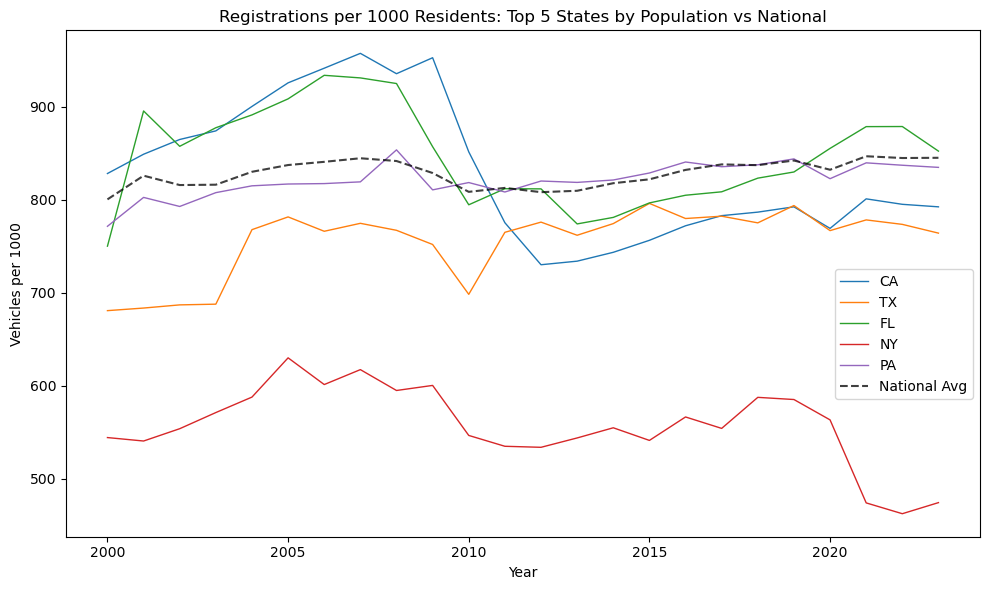

In [32]:
# Small multiple line chart for top 5 population states
pop_top5 = state_pop[state_pop['Year']==2023].nlargest(5, 'Population')['State']
sel = reg_per_cap[reg_per_cap['State'].isin(pop_top5)]

plt.figure(figsize=(10,6))
for st in pop_top5:
    plt.plot(sel[sel['State']==st]['Year'], sel[sel['State']==st]['Vehicles_per_1000'], label=st, linewidth=1)
plt.plot(national_per_cap['Year'], national_per_cap['Vehicles_per_1000'], label='National Avg', linewidth=1.5, linestyle='--', color='black', alpha=.75)
plt.title('Registrations per 1000 Residents: Top 5 States by Population vs National')
plt.xlabel('Year')
plt.ylabel('Vehicles per 1000')
plt.legend(loc='center right', bbox_to_anchor=(1, 0.4))
plt.grid(False)
plt.tight_layout()
plt.show()

**Plot National Registrations per 1000 Residents Over 2000-2023**

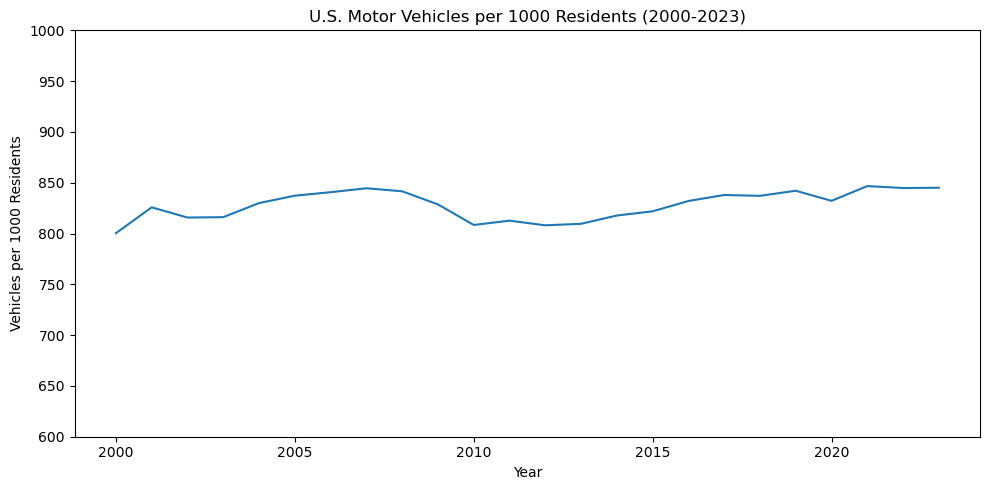

In [34]:
plt.figure(figsize=(10,5))
sns.lineplot(data=national_per_cap, x='Year', y='Vehicles_per_1000')
plt.title('U.S. Motor Vehicles per 1000 Residents (2000-2023)')
plt.xlabel('Year')
plt.ylabel('Vehicles per 1000 Residents')
plt.ylim(600, 1000)
plt.grid(False)
plt.tight_layout()
plt.show()

**Create Scatter Plot**

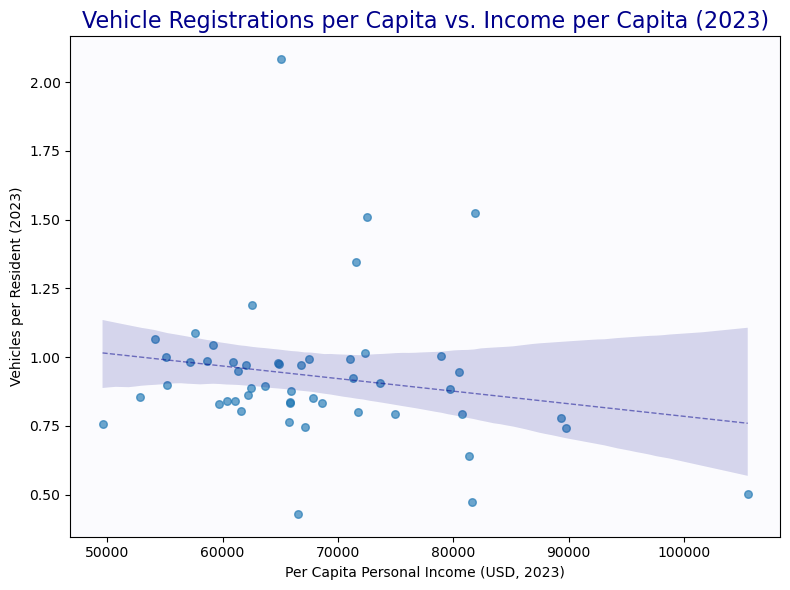

In [36]:
# !pip install mplcursors

# import mplcursors

final_per_cap = final2023
final_per_cap['Vehicles_per_cap'] = final2023['Vehicles'] / final2023['Population']

# Scatter plot
plt.figure(figsize=(8,6))
sns.set_style({"axes.facecolor": "#fbfbfe"})

# Save the return value from sns.regplot
scatter = sns.regplot(data=final_per_cap, x='Income_per_capita', y='Vehicles_per_cap', 
                     scatter_kws={'s': 30, 'alpha': 0.65}, 
                     line_kws={'color': 'darkblue', 'linewidth': 1, 'linestyle': '--', 
                              'label': 'Regression Line', 'alpha': 0.5})

plt.xlabel('Per Capita Personal Income (USD, 2023)')
plt.ylabel('Vehicles per Resident (2023)')
plt.title('Vehicle Registrations per Capita vs. Income per Capita (2023)', 
         fontdict={'fontsize': 16, 'color': 'darkblue'})
plt.tight_layout()

# Now cursor can access scatter
# cursor = mplcursors.cursor(scatter.collections[0], hover=True)
# cursor.connect("add", lambda sel: sel.annotation.set_text(
#    final_per_cap.index[sel.target.index]))

plt.show()

**Run Pearson Correlation**

In [38]:
# Correlation
corr = final2023['Income_per_capita'].corr(final2023['Vehicles_per_1000'])
# print('Pearson correlation: ', corr)
print('\033[1;34m', 'Pearson correlation: ', corr, '\033[0m')

 Pearson correlation:  -0.18670016969296635 


## **Analysis**

**National growth**

* Raw registrations rose every year from 2000 through 2023.
* Average annual growth ≈ 1.8 million vehicles; 2023 closed at a little over 286 million registrations. 

**2023 per-1000 map**
* Upper-Midwest states (Montana,Wyoming, North Dakota, South Dakota) top the chart, all exceeding 1 100 vehicles / 1 000 residents—i.e., more vehicles than people.
* The lowest rates cluster on the coasts and New York (≈ 540).

**State comparisons (top-5 population states vs. national)**
* Pennsylvania has been essentially flat and has been roughly equivelent to the national average.
* Florida and California have flattened after significant declines between 2010 and 2013.
* New York remains an outlier at ~650, reflecting its big urban transit base.

### Conclusions

* U.S. motorization is mature; total growth now comes more from population than from additional vehicles per household.
* State-level divergence persists: sparse, rural states continue to build oversized fleets relative to population while coastal metros stay flat.

References:  
*https://data.transportation.gov*  
*https://www.census.gov/*  
*https://apps.bea.gov/regional/*  